In [108]:
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [109]:
def load_excel_to_dataframe(file_path, sheet_name=0):
    """
    Reads an Excel file and returns its contents as a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the Excel file.
    - sheet_name (str or int, optional): The sheet name or index to read. Defaults to the first sheet (0).

    Returns:
    - DataFrame: The contents of the specified Excel sheet as a DataFrame.
    """
       
    try:
        # Use read_csv with delim_whitespace=True based on the image format
        # Adjust separator if necessary (e.g., sep=',' if it's actually comma-separated)
        df = pd.read_csv(
            file_path,
            parse_dates=['Datetime'], # Parse the 'Datetime' column
            index_col='Datetime'      # Set 'Datetime' as the index
        )

        # Check if index is already timezone-aware from parsing '+00:00'
        if df.index.tz is None:
            # If not timezone-aware, localize to UTC first (assuming +00:00 means UTC)
            # Note: pd.to_datetime with utc=True might be needed if parsing fails tz
            df.index = df.index.tz_localize('UTC')
        else:
            # If already timezone-aware (likely UTC), ensure it's standardized to UTC
            df.index = df.index.tz_convert('UTC')

        # Convert the UTC index to America/New_York timezone
        df.index = df.index.tz_convert("America/New_York")

        print(f"Successfully loaded data. Index type: {df.index.dtype}") # Debug print
        return df

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except KeyError as e:
        print(f"Error: Column required for index or parsing not found: {e}. Check CSV header.")
        return None
    except Exception as e:
        print(f"An error occurred during CSV loading or initial processing: {e}")
        return None


In [110]:
def process_dataframe(df):
    """
    Processes the DataFrame by filtering time, calculating technical indicators.
    Assumes df has a DatetimeIndex and columns: Open, High, Low, Close, Volume.

    Parameters:
    - df (DataFrame): The DataFrame to process (output from load_csv_to_dataframe).

    Returns:
    - DataFrame or None: The processed DataFrame, or None if input is invalid.
    """
    if df is None or df.empty:
        print("Error: Input DataFrame is None or empty in process_dataframe.")
        return None

    # --- Filter based on time using the DatetimeIndex ---
    # Keep rows where time is between 9:30 AM and 3:55 PM (inclusive) New York time
    df_filtered = df[((df.index.hour >=0) & (df.index.hour <= 23)) |
                     ((df.index.hour == 9) & (df.index.minute >= 30)) |
                     ((df.index.hour == 15) & (df.index.minute <= 55))]

    if df_filtered.empty:
        print("Warning: DataFrame is empty after time filtering.")
        # Decide whether to return the empty df or None
        # return None
        return df_filtered # Return empty df for consistency

    # --- Column renaming is removed as CSV headers seem correct ---
    # df = df.rename(columns={'o': 'Open', 'c': 'Close', 'h': 'High', 'l': 'Low', 'v': 'Volume'})

    # Make a copy to avoid SettingWithCopyWarning if df_filtered is a slice
    df_processed = df_filtered.copy()

    # --- Calculate additional processed columns ---
    # Extract hour from DatetimeIndex (optional, as filtering is done)
    df_processed['Hour'] = df_processed.index.hour

    # Ensure required columns exist before calculations
    required_cols = ['Open', 'Close', 'High', 'Low']
    if not all(col in df_processed.columns for col in required_cols):
        print(f"Error: Missing one or more required columns for calculations: {required_cols}")
        return None # Or handle differently

    # Use .loc to ensure assignment happens on the DataFrame/copy, not a temporary view
    df_processed.loc[:, 'Price Difference Ratio'] = ((df_processed['Close'] - df_processed['Open']) / df_processed['Open']) * 100
    df_processed.loc[:, 'Price Standard Deviation'] = df_processed['Open'].rolling(window=14).std()
    df_processed.loc[:, 'Momentum Indicator'] = df_processed['Close'] - df_processed['Close'].shift(1)
    df_processed.loc[:, 'Range Ratio'] = (df_processed['High'] - df_processed['Low']) / df_processed['Open']
    df_processed.loc[:, 'Price Range'] = df_processed['High'] - df_processed['Low']

    print("DataFrame processing complete.")
    print(df_processed.head()) # DEBUG

    return df_processed

In [111]:
def hourly_volatility_analysis(df):
    '''
    This function examines how trading patterns vary throughout the day by analyzing:

    Volume: Average trading volume per hour
        Higher volumes often indicate more active trading periods
        Used to identify peak trading hours and liquidity patterns


    Price Range: Average price volatility per hour
        Calculated as (High - Low) in each period
        Larger ranges indicate more price movement/volatility
        Helps identify hours with highest price volatility

    Momentum Indicator: Absolute average of momentum
        Takes the absolute value of momentum to measure strength regardless of direction
        Higher values indicate stronger price movements
        Using abs(mean) rather than mean(abs) shows overall directional strength

    '''
    hourly_volatility_df = df.groupby('Hour').agg({
        'Volume' : 'mean',
        'Price Range' : 'mean',
        'Momentum Indicator' : lambda x: abs(x.mean()),
        'Hour' : 'count'
    }).rename(columns = {
        'Volume': 'avgVolume',
        'Price Range': 'avgPriceRange',
        'Momentum Indicator': 'avgMomentum',
        'Hour': 'count'
    }).reset_index()

    return hourly_volatility_df

In [112]:
def momentum_reversal_analysis(df):
    """
    Identifies momentum reversals based on changes in the sign of the Momentum Indicator.

    Uses sign change detection: np.sign(current) != np.sign(previous)
        Positive to negative = Uptrend to downtrend
        Negative to positive = Downtrend to uptrend

    Tracks associated metrics:
        Timestamp (when reversal occurred)
        Current momentum value (confirming reversal)
        Previous momentum value (reversal strength)
        Volume during reversal
        Price range during reversal
    """
    if df is None or 'Momentum Indicator' not in df.columns:
        print("Error: Input DataFrame is invalid or missing 'Momentum Indicator' in momentum_reversal_analysis.")
        return None

    # Make a copy to avoid modifying the original DataFrame passed to the function
    df_analysis = df.copy()
    df_analysis['prevMomentum'] = df_analysis['Momentum Indicator'].shift(1) #NOTE; the first element will be NaN whe using shift(1)

    # Filter for rows where the sign changes and previous momentum is not NaN
    reversal_conditions = (
        (np.sign(df_analysis['Momentum Indicator']) != np.sign(df_analysis['prevMomentum'])) &
        (~df_analysis['prevMomentum'].isna()) &
        (df_analysis['Momentum Indicator'] != 0) # Optional: ignore zero momentum
    )
    momentum_reversals = df_analysis[reversal_conditions].assign(
        # --- CORRECTED LINE: Use df.index instead of df['Datetime'] ---
        Datetime=lambda x: x.index, # Use lambda to access index of the filtered df
        currentMomentum=lambda x: x['Momentum Indicator'],
        # prevMomentum is already calculated
        volume=lambda x: x['Volume'],
        priceRange=lambda x: x['Price Range']
    # Select and order the final columns
    )[['Datetime', 'currentMomentum', 'prevMomentum', 'volume', 'priceRange']]

    return momentum_reversals

In [113]:
# High Volume Price Impact Analysis
def high_volume_price_impact_analysis(df):
    """
    Identifies periods of high trading volume and analyzes the associated price impact.

    Volume Threshold: mean * 2
        Uses 2x average volume as significance threshold
        Identifies periods of unusually high activity
        Statistical outlier detection for volume spikes

    Tracks associated metrics:
        Timestamp (when high volume occurred)
        Volume value
        Price change ratio (impact on price during that period)
        Price range (volatility during high volume period)
    """
    if df is None or not all(col in df.columns for col in ['Volume', 'Price Difference Ratio', 'Price Range']):
        print("Error: Input DataFrame is invalid or missing required columns in high_volume_price_impact_analysis.")
        return None

    volume_threshold = df['Volume'].mean() * 2

    # Filter for high volume events
    high_volume_df = df[df['Volume'] > volume_threshold]

    # Assign relevant columns for the analysis
    high_volume_events = high_volume_df.assign(
        # --- CORRECTED LINE: Use df.index instead of df['Datetime'] ---
        Datetime=lambda x: x.index, # Use lambda to access index of the filtered df
        volume=lambda x: x['Volume'],
        priceChange=lambda x: x['Price Difference Ratio'],
        priceRange=lambda x: x['Price Range']
    # Select and order the final columns
    )[['Datetime', 'volume', 'priceChange', 'priceRange']]

    return high_volume_events

In [114]:
def create_stock_pattern_visualizations(df, hourly_volatility_df, momentum_reversals, high_volume_events, filename_no_ext):
    plt.figure(figsize=(20,20))
    plt.suptitle('Comprehensive Stock Pattern Analysis', fontsize=16)

    # 1. Hourly Volume Analysis
    plt.subplot(3, 2, 1)
    plt.bar(hourly_volatility_df['Hour'], hourly_volatility_df['avgVolume'])
    plt.title('Average Volume by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Volume')
    plt.xticks(rotation=45)

    # 2. Hourly Price Range Analysis
    plt.subplot(3, 2, 2)
    plt.bar(hourly_volatility_df['Hour'], hourly_volatility_df['avgPriceRange'], color='orange')
    plt.title('Average Price Range by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Price Range')
    plt.xticks(rotation=45)

    # 3. Momentum Reversals Scatter
    plt.subplot(3, 2, 3)
    plt.scatter(momentum_reversals['currentMomentum'], momentum_reversals['volume'],
                alpha=0.6, c=momentum_reversals['priceRange'], cmap='viridis')
    plt.colorbar(label='Price Range')
    plt.title('Momentum Reversals: Momentum vs Volume')
    plt.xlabel('Current Momentum')
    plt.ylabel('Volume')

    # 4. High Volume Events
    plt.subplot(3, 2, 4)
    plt.scatter(high_volume_events['volume'], high_volume_events['priceChange'],
                alpha=0.6, c=high_volume_events['priceRange'], cmap='plasma')
    plt.colorbar(label='Price Range')
    plt.title('High Volume Events: Volume vs Price Change')
    plt.xlabel('Volume')
    plt.ylabel('Price Change (%)')

    # 5. Correlation Heatmap
    plt.subplot(3, 2, 5)
    correlation_columns = ['Volume', 'Open', 'Close', 'High', 'Low', 'Price Range']
    correlation_matrix = df[correlation_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')

    # 6. Momentum Reversal Histogram
    plt.subplot(3, 2, 6)
    plt.hist(momentum_reversals['currentMomentum'], bins=30, edgecolor='black')
    plt.title('Distribution of Momentum at Reversal Points')
    plt.xlabel('Momentum')
    plt.ylabel('Frequency')

    plt.tight_layout()
    # save the graph to a file
    plt.savefig(f'PatternAnalysis_{filename_no_ext}.png')
    plt.show()


In [115]:
def main ():

    ## CHOOSE THE CORRECT FILE PATH (comment off the other ones)
    #data from polygon.io
    file_path = 'russ_strategy_stock/data/SPX500_M15.csv'  # Replace with your actual file path

    # # data from yahoo
    # file_path = 'data/generated_data/SPY_yfinance_7d_5m_2025-01-24_to_2025-02-03_processed.xlsx'  # Replace with your actual file path

    sheet_name = 0         # Replace with your actual sheet name

    # Step 1: Load the data
    df_raw = load_excel_to_dataframe(file_path)
    # Step 2: Check if loading was successful and process the data
    if df_raw is not None:
        df = process_dataframe(df_raw)

        if df is not None and not df.empty:
            # --- Continue with your analysis using df_processed ---
            print("\nProcessed DataFrame Info:")
            df.info()
            # Example: df_hourly_volatility = hourly_volatility_analysis(df_processed)
            # ...
        else:
            print("Processing resulted in an empty or invalid DataFrame.")
    else:
        print("Failed to load data, cannot proceed with processing.")

    #### KNOWN Pattern Analysis
    df_hourly_volatility = hourly_volatility_analysis(df)
    df_momentum_reversals = momentum_reversal_analysis(df)
    df_high_volume_price_impact = high_volume_price_impact_analysis(df)

    # get the filename without the extension
    filename = os.path.basename(file_path)
    filename_no_ext = os.path.splitext(filename)[0]

    # Create visualizations
    create_stock_pattern_visualizations(df, df_hourly_volatility, df_momentum_reversals, df_high_volume_price_impact, filename_no_ext)


Successfully loaded data. Index type: datetime64[ns, America/New_York]
DataFrame processing complete.
                             Open    High     Low   Close  Volume  Hour  \
Datetime                                                                  
2020-01-01 18:00:00-05:00  3236.6  3239.5  3235.0  3239.5     194    18   
2020-01-01 18:15:00-05:00  3239.8  3240.9  3239.4  3240.8      77    18   
2020-01-01 18:30:00-05:00  3240.6  3240.8  3238.8  3238.8      69    18   
2020-01-01 18:45:00-05:00  3239.0  3239.4  3238.0  3238.0      38    18   
2020-01-01 19:00:00-05:00  3238.2  3238.8  3237.6  3238.0      33    19   

                           Price Difference Ratio  Price Standard Deviation  \
Datetime                                                                      
2020-01-01 18:00:00-05:00                0.089600                       NaN   
2020-01-01 18:15:00-05:00                0.030866                       NaN   
2020-01-01 18:30:00-05:00               -0.055545       

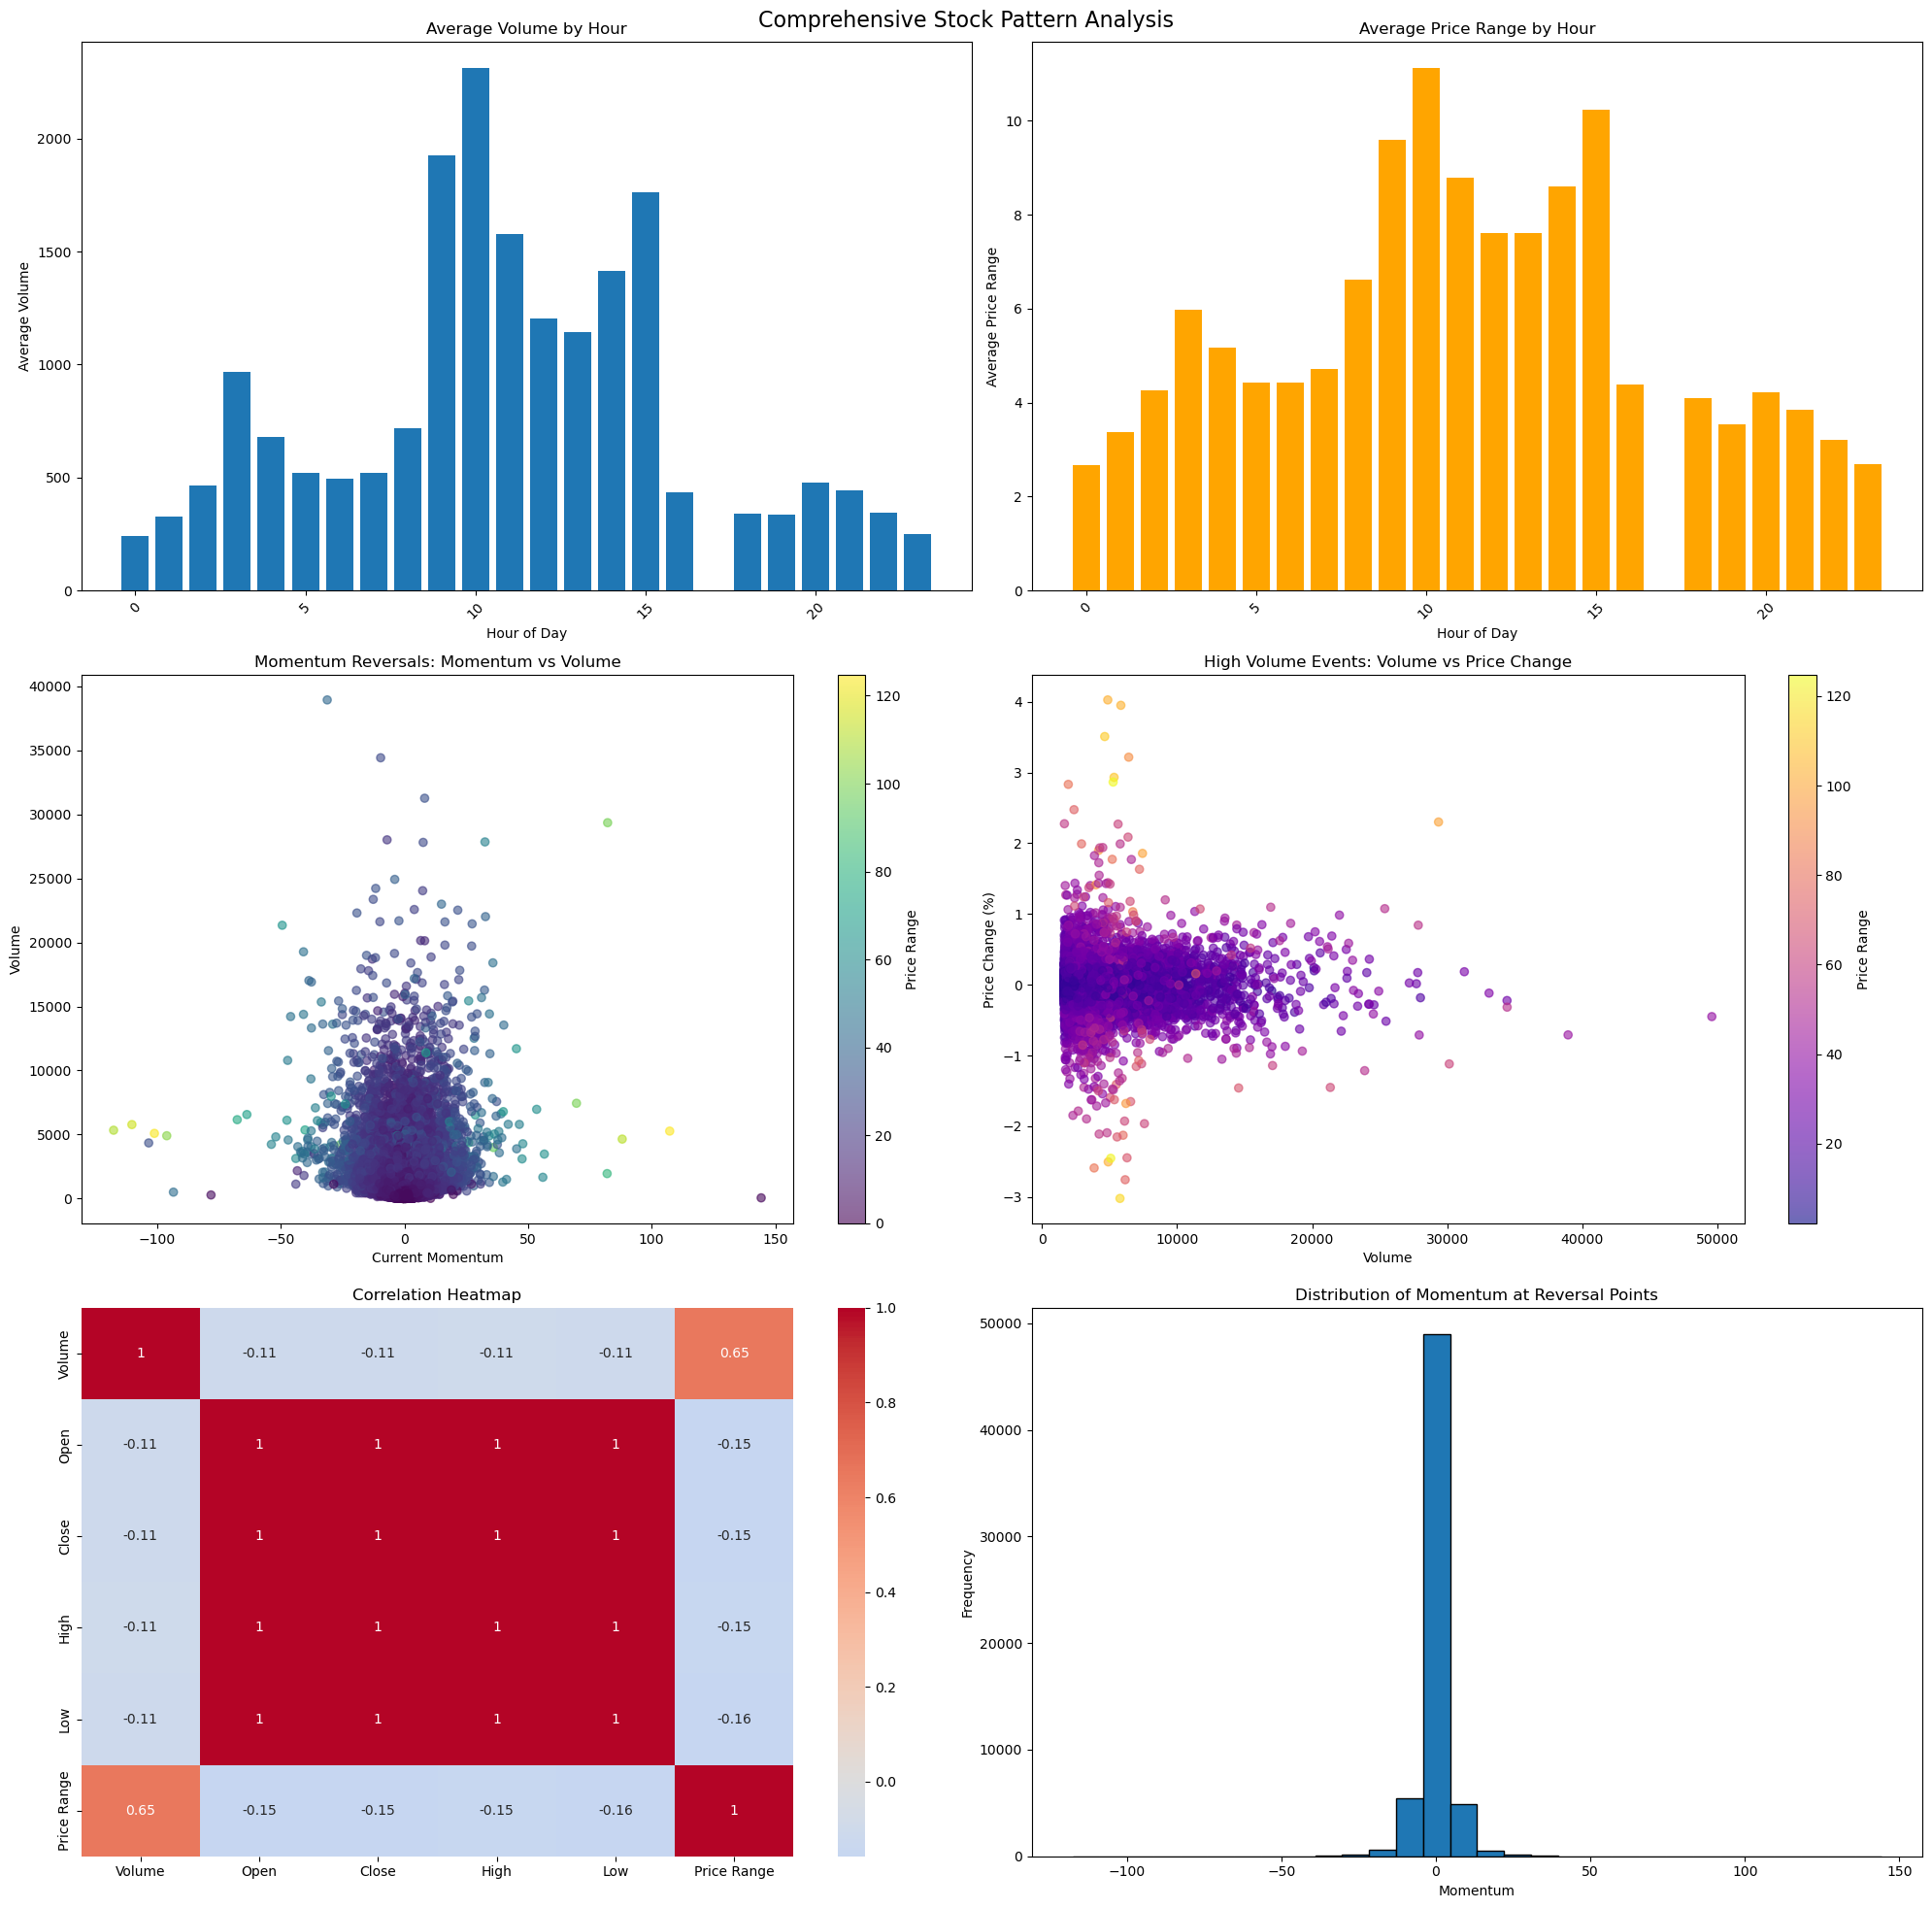

In [116]:
if __name__ == '__main__':
    main()